# Final Project - CIS5200

***Team Members: Lorenzo Lucena Maguire , Ruturaj A. Nanoti, Siddhant Mathur***

The Goal of this project is to predict the chess board positions based on Images. The labels are present in the form of ***FEN Notation***.

## Configuring Kaggle

Install `kaggle` package to download the data directly into the notebook. Then create a `.kaggle` directory in the `home` folder.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Upload your `kaggle.json` file obtained from Kaggle. To create this file, go to `Account` -> `Create New API Token`. Reference Link to the whole Procedure : https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Getting the Data

Download the dataset from Kaggle.

In [ ]:
! kaggle datasets download koryakinp/chess-positions

100% 4.01G/4.01G [03:19<00:00, 24.6MB/s]
100% 4.01G/4.01G [03:19<00:00, 21.6MB/s]


In [ ]:
! unzip chess-positions.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/b1K5-6rB-5k2-5r2-1b6-8-5n2-8.jpeg  
  inflating: train/b1K5-8-3k4-3p4-8-3B1r2-1b6-4N3.jpeg  
  inflating: train/b1K5-8-8-2p3p1-5k2-8-8-7R.jpeg  
  inflating: train/b1K5-8-8-8-2qr1N2-8-6nk-3b4.jpeg  
  inflating: train/b1K5-r7-4kb2-R4Q1p-b7-1pb5-5P2-8.jpeg  
  inflating: train/b1KB4-2B5-3p4-1BB5-3k1n2-p1r5-2n5-5r1q.jpeg  
  inflating: train/b1Kb4-6P1-n2Q3k-8-4N1n1-2b2P2-8-8.jpeg  
  inflating: train/b1Kr4-8-q7-8-1bB5-8-2k1P1RR-8.jpeg  
  inflating: train/b1Kr4-P7-R2R4-1b3B2-3Pr3-4Nk2-8-4R3.jpeg  
  inflating: train/b1N1k3-K1q5-1P1B4-2R5-3N3Q-3brP2-8-1B1n4.jpeg  
  inflating: train/b1N1n1q1-R5RQ-1N2r2P-3n4-3k4-8-3n3N-K7.jpeg  
  inflating: train/b1N1qn2-1P5k-b3K1p1-8-2B4n-7N-5B2-1b2B3.jpeg  
  inflating: train/b1N1r1k1-2R5-1r2b3-5KpR-N1P5-8-6R1-7B.jpeg  
  inflating: train/b1N1r3-2P1r1k1-3b4-8-3K3b-2rB4-7p-8.jpeg  
  inflating: train/b1N2K1b-2Bp4-4B2k-b2p4-8-7n-3p3n-2B2B2.jpeg  
  inflating: train/b1N2b1R-3n4-P2P4-1n2K

## Importing the Necessary Libraries

In [ ]:
import random 
import pandas as pd
import sys
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
import glob
import re
import cv2
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")      
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from PIL import Image

! pip install torchinfo
from torchinfo import summary

! pip install python-chess
import chess.svg
import chess
import IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Understanding the Data

In [ ]:
train_path = glob.glob("./dataset/train/*.jpeg")
test_path = glob.glob("./dataset/test/*.jpeg")

In [ ]:
def get_fen_from_path(path_to_img):
    # Remove everything before the second `/`, including the `/`.
    final_str = path_to_img[path_to_img.rfind('/')+1:]
    # Remove `.jpeg`
    return final_str[:-5]

In [ ]:
print(train_path[15])
print(get_fen_from_path(train_path[15]))
print("")
print(test_path[15])
print(get_fen_from_path(test_path[15]))

./dataset/train/4k3-1P6-1P6-p2Q2r1-K7-8-3P3R-N2Q4.jpeg
4k3-1P6-1P6-p2Q2r1-K7-8-3P3R-N2Q4

./dataset/test/N7-4p1n1-3R4-6N1-K5p1-1Nk5-1B2NP2-N7.jpeg
N7-4p1n1-3R4-6N1-K5p1-1Nk5-1B2NP2-N7


### Encoding and Reconstruction of the FEN Notation
The FEN notation is now converted to a 64 x 13 matrix that represents the position of each piece on the board based on the FEN label. Each `row` consists of 13 columns, with every column representing one of the 6 pieces in `black` and
`white` camp. Finally the last column denotes if that square is empty.


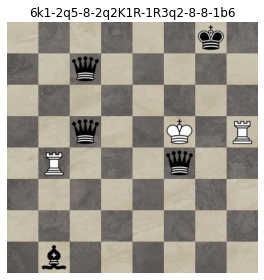

In [ ]:
img_rand=cv2.imread(train_path[16])
plt.imshow(cv2.cvtColor(img_rand, cv2.COLOR_BGR2RGB))
plt.title(get_fen_from_path(train_path[16]))
plt.axis('off')
plt.tight_layout()
plt.show()

To understand this better let's take an example : `2b4B-2b1b3-5p1r-6R1-3K4-4Pr2-1pN1k3-3Nr3`. This is the label/position
for the state of a chess board. The description for each row is separated using the `-` delimiter in the string. So, the first element (which is `2b4B`) in the FEN string describes the first row. Let's dissect this further. Here, `2` says that the first couple squares in the first row are empty which is be validated by the image. Then the `b` letter states that there is a ***Black Bishop*** on the 3rd square in the first row. Note that lower case letters are used to represent the ***black*** pieces, and the uppercase letters are used to represent the ***white*** pieces. Then, the number `4` again says that there are four empty squares after the black bishop. Finally, a `B` says that there is a white bishop present. If you notice, we have traversed and sucessfully encoded all the 8 squares of the first row. In the exact same manner all the other rows of the board are encoded.

Now that we understand the FEN notation used here, we need to encode this with numbers to train our model.

In [ ]:
# Columns in the encoded matrix.
#         Black        |          White        |  Empty
#      b k n p q r     |       B K N P Q R     |    _
piece_list = np.array(['b', 'k', 'n', 'p', 'q', 'r',
                       'B', 'K', 'N', 'P', 'Q', 'R',
                       'empty'])

def fen_to_matrix(fen_label):
  # Initialize the Encoded Matrix.
  encoded_mat = np.zeros((64,13))
  # Row Pointer to keep track of the current row in the matrix.
  row_pointer = 0
  # Iterate over each of the letters in the `fen_label`. 
  for letter in fen_label:
    # Continue without doing anything, if the `-` delimiter is
    # found.
    if letter == '-':
      continue
    else:
      # Get the index for the current letter in the `piece_list`.
      piece_idx = np.argwhere(piece_list == letter)
      # Check if the current element is a letter or a number.
      if len(piece_idx) != 0:
        encoded_mat[row_pointer, piece_idx] = 1
        row_pointer += 1
      else:
        # If the element was a number, type cast it to an `int`.
        # Then set the empty column in the rows for that number
        # of rows.
        for i in range(int(letter)):
          encoded_mat[row_pointer, 12] = 1
          row_pointer += 1
  
  # Flatten the matrix
  encoded_mat = encoded_mat.reshape((encoded_mat.shape[0] * encoded_mat.shape[1],))

  return encoded_mat

In [ ]:
def reconstruct_fen(encoded_mat):
  encoded_mat_copy = encoded_mat.copy()
  encoded_mat_copy = encoded_mat_copy.reshape((64, 13))
  n,p = encoded_mat_copy.shape
  # Create an empty array for the fen label.
  fen_label = []
  # Initialize a counter variable that counts 
  # the number of empty spots.
  empty_count = 0
  # Iterate over all `64` rows.
  for i in range(n):
    # Append a `-` if 8 squares are done.
    if (i) % 8 == 0 and i != 0:
      fen_label.append('-')
    # Check if the square is empty.
    if encoded_mat_copy[i, 12] == 1:
      # If the square is empty check if the next square is also empty
      # or if we are switching to the next row. If not, append the
      # `empty_count` to the `fen_label` and set `empty_count` to `0`.
      # Otherwise, just keep updating `empty_count`.
      if (i < n-1 and encoded_mat_copy[i+1, 12] != 1) or ((i+1) % 8 == 0):
        fen_label.append(str(empty_count+1))
        empty_count = 0
      else:
        empty_count += 1
    # If the square is not empty, find the piece that is present in that
    # row. Based on that append the letter denoting that piece to `fen_label`.
    else:
      piece_idx = np.argwhere(encoded_mat_copy[i] == 1).reshape(-1).item()
      fen_label.append(piece_list[piece_idx])
  
  # Finally convert the whole array into a string. We finally have our FEN
  # reconstructed now.
  fen_label = "".join(fen_label)
  return fen_label

In [ ]:
reconstructed_fen_notation = reconstruct_fen(fen_to_matrix(get_fen_from_path(train_path[20])))

if reconstructed_fen_notation == get_fen_from_path(train_path[20]):
  print("Matched")

Matched


## Loading the Data
References : 

*   https://www.youtube.com/watch?v=NVxCKdp0NhQ
*   https://pytorch.org/tutorials/beginner/data_loading_tutorial.html



In [ ]:
train_data_size = 8000
test_data_size = 2000

def load_data(data_path, data_size):
  data_ = []
  data_labels = []
  for i in range(data_size):
    curr_img = np.array(Image.open(train_path[i]).convert('L'))
    # curr_img = cv2.imread(train_path[i])
    # curr_img = cv2.resize(curr_img, (240,240))
    # curr_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
    # curr_img = cv2.normalize(curr_img, curr_img,  0, 255, cv2.NORM_MINMAX)
    data_.append(curr_img)
    data_labels.append(fen_to_matrix(get_fen_from_path(train_path[i])))
  
  return np.array(data_), np.array(data_labels)

X_train, y_train = load_data(train_path, train_data_size)
X_train, y_train = X_train, y_train
X_test, y_test = load_data(test_path, test_data_size)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print("")
print(X_test.shape)
print(y_test.shape)

(8000, 400, 400)
(8000, 832)

(2000, 400, 400)
(2000, 832)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class Chess_Datatset(Dataset):
  def __init__(self, X, y, transform=None):
    self.dataset = X
    self.labels = y
    self.transform = transform
    # self.dataset = torch.tensor(self.df).float()
    # self.labels = torch.tensor(self.df_labels).float()
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    img = Image.fromarray(self.dataset[idx], mode='L')
    if self.transform:
      img = self.transform(img)
    return img, self.labels[idx]

In [ ]:
mean = 0.5
std = 0.5

transformation = transforms.Compose([transforms.Resize(240),
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean,), (std,))
                                    ])

In [ ]:
X_train_new = X_train.copy()
print(X_train_new.shape)

train_data = Chess_Datatset(X_train_new, y_train, transform=transformation)
train_data
# image, labels = train_data.__getitem__(0)
# print(np.array(image).shape)
# print(np.array(labels).shape)

(8000, 400, 400)


In [ ]:
X_test_new = X_test.copy()
print(X_test_new.shape)

# N, H, W, C -> N, C, H, W

test_data = Chess_Datatset(X_test_new, y_test, transform=transformation)
test_data

(2000, 400, 400)


In [ ]:
train_data_loader = DataLoader(train_data, batch_size=128, num_workers=2,
                               shuffle=True, drop_last=False)
test_data_loader = DataLoader(test_data, batch_size=128, num_workers=2,
                              shuffle=True, drop_last=False)

## Training and Testing Methods

In [ ]:
import torch.optim as optim

def train_model(model, epochs = 50):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  train_loss = []
  accuracies = []
  # training iteration
  for epoch in range(epochs):
      running_loss = 0
      curr_correct = 0
      curr_acc = 0
      total_num = 0
      for itr, (image, label) in enumerate(train_data_loader):
          image, label = image.cuda(), label.cuda()
          # zero gradient
          optimizer.zero_grad()
          # forward path
          y_predicted = model(image)
          loss = criterion(y_predicted, label)
          running_loss += loss.item()
          # backpropagating
          loss.backward()
          # optimizes the weights
          optimizer.step()
          # Print training accuracy
          curr_correct += get_accuracy(label, y_predicted, epoch)
          total_num += float(len(label))
      train_loss.append(running_loss)
      curr_acc = curr_correct/total_num
      accuracies.append(curr_acc)
      print(f'epoch: {epoch+1}, loss: {running_loss:.4f}, accuracy: {curr_acc:.4f}')
  # Visualize loss over epochs
  print("")
  plt.plot(np.arange(1, epochs+1), train_loss, label="Train loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("Training Loss Plot")
  plt.legend(loc='upper right')
  plt.show()
  plt.close()
  
  print("")
  plt.plot(np.arange(1, epochs+1), accuracies, label="Train Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title("Training Accuracy Plot")
  plt.legend(loc='upper left')
  plt.show()
  plt.close()

def test_model(model):
  device = torch.device("cpu")
  model.to(device)
  correct = 0
  total = 0
  curr_out = torch.from_numpy(np.zeros((832,)))
  with torch.no_grad():
      for itr, (image, label) in enumerate(test_data_loader):
          predicted = np.zeros(label.shape)
          outputs = model(image)
          for i in range(len(label)):
            curr_out = outputs.data[i,:]
            curr_out = torch.reshape(curr_out, (64,13))
            curr_out = curr_out.numpy()
            for j in range(len(curr_out)):
              max_indx =  np.argwhere(curr_out[j,:] == np.max(curr_out[j,:]))
              not_max_indx =  np.argwhere(curr_out[j,:] != np.max(curr_out[j,:]))
              curr_out[j,max_indx] = 1
              curr_out[j,not_max_indx] = 0
            curr_out = curr_out.reshape((832,))
            if reconstruct_fen(curr_out) == reconstruct_fen(label.numpy()[i,:]):
              correct += 1
            predicted[i] = curr_out
            curr_out = torch.from_numpy(curr_out)
          predicted = torch.from_numpy(predicted)
          total += float(len(label))
      print(correct)
      accuracy = correct / (total)
      print(f'Accuracy of Neural Network is {accuracy:.4f}')

def test_model_mlp(model):
  device = torch.device("cuda:0")
  model.to(device)
  correct = 0
  total = 0
  curr_out = torch.from_numpy(np.zeros((832,)))
  with torch.no_grad():
      for itr, (image, label) in enumerate(train_data_loader):
          image, label = image.cuda(), label.cuda()
          # predicted = np.zeros(label.shape)
          outputs = model(image)
          correct += get_accuracy(label, outputs, 0)
          total += float(len(label))
      print(correct)
      accuracy = correct / (total)
      print(f'Accuracy of Neural Network is {accuracy:.4f}')

def get_accuracy(label, outputs, epoch_num):
  predicted = torch.cuda.FloatTensor(label.shape).fill_(0)
  correct = 0
  total = 0
  with torch.no_grad():
    for i in range(len(label)):
      curr_out = outputs.data[i,:]
      curr_out = torch.reshape(curr_out, (64,13))
      for j in range(len(curr_out)):
        max_indx = torch.argmax(curr_out[j,:])
        curr_out[j,:] = torch.where(curr_out[j,:] == curr_out[j,max_indx], curr_out[j,:], torch.cuda.DoubleTensor(1,).fill_(0))
        curr_out[j,max_indx] = 1
      curr_out = torch.reshape(curr_out, (832,))
      if torch.equal(curr_out,label[i,:]):
        correct += 1
      predicted[i] = curr_out
    return correct

In [ ]:
def print_wrong_predictions(model):
  image, label = next(iter(test_data_loader))
  predicted = np.zeros(label.shape)
  outputs = model(image)
  for i in range(len(label)):
    curr_out = outputs.data[i,:]
    curr_out = torch.reshape(curr_out, (64,13))
    curr_out = curr_out.numpy()
    for j in range(len(curr_out)):
      max_indx =  np.argwhere(curr_out[j,:] == np.max(curr_out[j,:]))
      not_max_indx =  np.argwhere(curr_out[j,:] != np.max(curr_out[j,:]))
      curr_out[j,max_indx] = 1
      curr_out[j,not_max_indx] = 0
    curr_out = curr_out.reshape((832,))
    if reconstruct_fen(curr_out) != reconstruct_fen(label.numpy()[i,:]):
      print(reconstruct_fen(curr_out), "|", reconstruct_fen(label.numpy()[i,:]))
      board_predicted = chess.Board(reconstruct_fen(curr_out).replace('-', '/'))
      board_label = chess.Board(reconstruct_fen(label.numpy()[i,:]).replace('-', '/'))
      html_code_pred = chess.svg.board(board_predicted, size=300)
      html_code_label = chess.svg.board(board_label, size=300)
      print("Predicted Position")
      display(IPython.display.HTML(html_code_pred))
      print("True Position")
      display(IPython.display.HTML(html_code_label))
      print("")


## MLP-Mixer

MLP-Mixers propose to divide the input into patches.

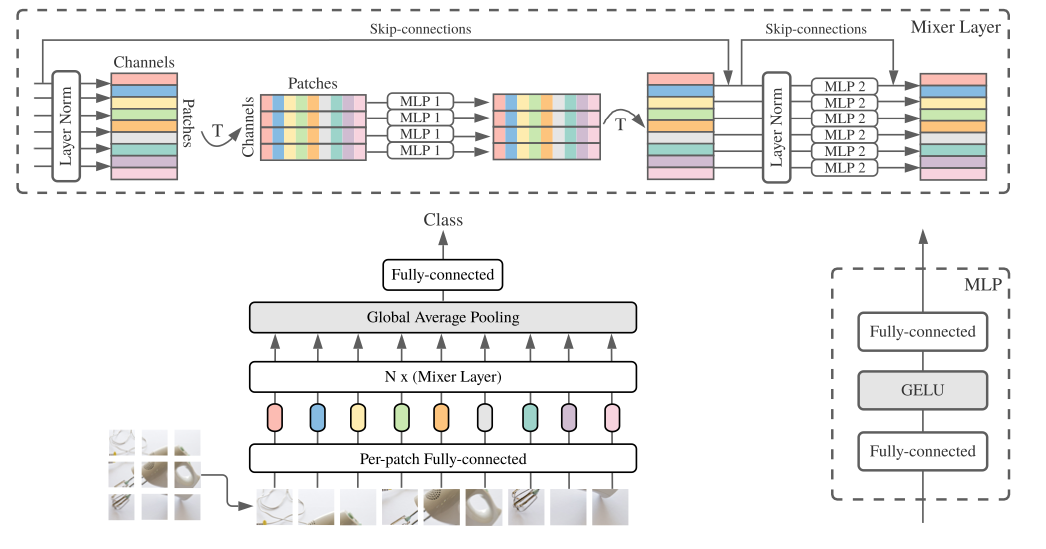


Link to paper: https://arxiv.org/pdf/2105.01601.pdf


In [ ]:
class MLPBlock(nn.Module): 
    def __init__(self, dim):
      super().__init__()
      self.mlp_dim = dim

    def forward(self, x):
      input_dim = x.shape[-1]
      x = nn.Linear(input_dim, self.mlp_dim, device = "cuda:0")(x)
      # x = nn.Linear(input_dim, self.mlp_dim)(x)
      x = nn.GELU()(x)
      return nn.Linear(self.mlp_dim, input_dim, device = "cuda:0")(x)
      # return nn.Linear(self.mlp_dim, input_dim)(x)

class MLPMixerLayer(nn.Module):
  def __init__(self, num_channels, tokens_mlp_dim, channels_mlp_dim):
    super(MLPMixerLayer, self).__init__()
    self.tokens_mlp_block = MLPBlock(tokens_mlp_dim)
    self.layer_norm1 = nn.LayerNorm(num_channels, device = "cuda:0")
    # self.layer_norm1 = nn.LayerNorm(num_channels)
    self.layer_norm2 = nn.LayerNorm(num_channels, device = "cuda:0")
    # self.layer_norm2 = nn.LayerNorm(num_channels)
    self.channels_mlp_block = MLPBlock(channels_mlp_dim)
  
  def forward(self, x):
    y = self.layer_norm1(x)
    y = y.transpose(1,2)
    y = self.tokens_mlp_block(y)
    y = y.transpose(1,2)
    x = x + y
    y = self.layer_norm2(x)
    x = x + self.channels_mlp_block(y)
    return x

class MLPMixer(nn.Module):

  def __init__(self, 
               input_dim = (128, 240, 240),
               num_channels = 900, 
               tokens_mlp_dim = 2048, 
               channels_mlp_dim = 2048, 
               num_mixer_layers = 4, 
               patch_size = 30):
    super(MLPMixer, self).__init__()
    

    self.num_channels = num_channels
    self.tokens_mlp_dim = tokens_mlp_dim
    self.channels_mlp_dim = channels_mlp_dim
    self.embed_patches = nn.Conv2d(1, num_channels, kernel_size=patch_size, stride=patch_size)

    # Last linear layer receives a tensor of shape (num_patches, 1)
    self.linear = nn.Linear(num_channels, 64*13)
    self.mixer_layers = nn.Sequential(
        *[MLPMixerLayer(self.num_channels, self.tokens_mlp_dim, self.channels_mlp_dim) for _ in range(num_mixer_layers)]
    )

  def forward(self, x):
    # Divide input into patches
    x = self.embed_patches(x)
    x = x.view(x.shape[0], x.shape[2] * x.shape[3] , x.shape[1])
    x = self.mixer_layers(x)
    x = x.mean(dim=1)
    x = self.linear(x)
    return x

In [ ]:
MLPMixerModel = MLPMixer()
MLPMixerModel = MLPMixerModel.to('cuda:0')
summary(MLPMixerModel, input_size=(128, 1, 240, 240))

Layer (type:depth-idx)                   Output Shape              Param #
MLPMixer                                 [128, 832]                --
├─Conv2d: 1-1                            [128, 900, 8, 8]          810,900
├─Sequential: 1-2                        [128, 64, 900]            --
│    └─MLPMixerLayer: 2-1                [128, 64, 900]            --
│    │    └─LayerNorm: 3-1               [128, 64, 900]            1,800
│    │    └─MLPBlock: 3-2                [128, 900, 64]            --
│    │    └─LayerNorm: 3-3               [128, 64, 900]            1,800
│    │    └─MLPBlock: 3-4                [128, 64, 900]            --
│    └─MLPMixerLayer: 2-2                [128, 64, 900]            --
│    │    └─LayerNorm: 3-5               [128, 64, 900]            1,800
│    │    └─MLPBlock: 3-6                [128, 900, 64]            --
│    │    └─LayerNorm: 3-7               [128, 64, 900]            1,800
│    │    └─MLPBlock: 3-8                [128, 64, 900]            -

epoch: 1, loss: 21188.5942, accuracy: 0.0000
epoch: 2, loss: 20356.0015, accuracy: 0.0000
epoch: 3, loss: 20005.8209, accuracy: 0.0000
epoch: 4, loss: 19584.6549, accuracy: 0.0000
epoch: 5, loss: 19359.5304, accuracy: 0.0000
epoch: 6, loss: 19241.3532, accuracy: 0.0000
epoch: 7, loss: 19132.7422, accuracy: 0.0000
epoch: 8, loss: 19076.1822, accuracy: 0.0000
epoch: 9, loss: 19065.8399, accuracy: 0.0000
epoch: 10, loss: 19013.3846, accuracy: 0.0000
epoch: 11, loss: 18979.8526, accuracy: 0.0000
epoch: 12, loss: 18877.2685, accuracy: 0.0000
epoch: 13, loss: 18814.5504, accuracy: 0.0000
epoch: 14, loss: 18691.6672, accuracy: 0.0000
epoch: 15, loss: 18582.7173, accuracy: 0.0005
epoch: 16, loss: 18466.6170, accuracy: 0.0004
epoch: 17, loss: 18359.6492, accuracy: 0.0015
epoch: 18, loss: 18288.7692, accuracy: 0.0034
epoch: 19, loss: 18180.9679, accuracy: 0.0065
epoch: 20, loss: 18144.3269, accuracy: 0.0081
epoch: 21, loss: 18057.9692, accuracy: 0.0146
epoch: 22, loss: 17989.9105, accuracy: 0.02

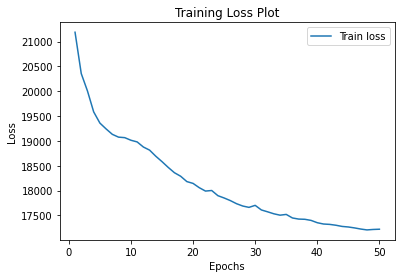

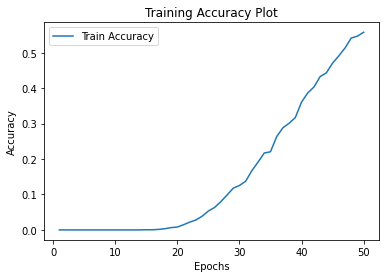

In [ ]:
train_data_loader = DataLoader(train_data, batch_size=128, num_workers=2,
                               shuffle=True, drop_last=False)
test_data_loader = DataLoader(test_data, batch_size=128, num_workers=2,
                              shuffle=True, drop_last=False)

train_model(MLPMixerModel)

In [ ]:
test_model_mlp(MLPMixerModel)

In [ ]:
print_wrong_predictions(MLPMixerModel)

## CNN Architecture

In [ ]:
def param_calc(in_size, kernel_size_list, stride_list, padding_list):
  out_list = []
  curr_size = in_size
  for i in range(len(kernel_size_list)):
    curr_size = ((in_size - kernel_size_list[i] + 2*padding_list[i])/stride_list[i]) + 1
    out_list.append(curr_size)
    in_size = curr_size
  return out_list

param_calc(240, [11, 2, 7, 2], [3, 2, 2, 2], [2, 0, 2, 0])

[78.66666666666667, 39.333333333333336, 19.166666666666668, 9.583333333333334]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#(w-k+2p)/s + 1 = 40 -> 120, 60, 60, 30, 30, 15

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=11, stride=3, padding=2)
        self.relu = torch.nn.ReLU()
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv_2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=2, padding=2)
        self.relu = torch.nn.ReLU()
        self.max_pool2d_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = torch.nn.Dropout(p=0.05)
        
        self.linear_1 = torch.nn.Linear(9 * 9 * 32, 2048)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(2048, 832)
        
    def forward(self, x):

        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)

        x = self.relu(self.conv_2(x))
        x = self.max_pool2d_1(x)

        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
 
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)

        return x

In [ ]:
NeuralNetModel = Net()
batch_size = 128
summary(NeuralNetModel, input_size=(batch_size, 1, 240, 240))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [128, 832]                --
├─Conv2d: 1-1                            [128, 16, 78, 78]         1,952
├─ReLU: 1-2                              [128, 16, 78, 78]         --
├─MaxPool2d: 1-3                         [128, 16, 39, 39]         --
├─Conv2d: 1-4                            [128, 32, 19, 19]         25,120
├─ReLU: 1-5                              [128, 32, 19, 19]         --
├─MaxPool2d: 1-6                         [128, 32, 9, 9]           --
├─Dropout: 1-7                           [128, 2592]               --
├─Linear: 1-8                            [128, 2048]               5,310,464
├─ReLU: 1-9                              [128, 2048]               --
├─Linear: 1-10                           [128, 832]                1,704,768
Total params: 7,042,304
Trainable params: 7,042,304
Non-trainable params: 0
Total mult-adds (G): 3.58
Input size (MB): 29.49
Forward/b

Train and test the Neural Net

epoch: 1, loss: 20464.9380, accuracy: 0.0000
epoch: 2, loss: 20019.7151, accuracy: 0.0000
epoch: 3, loss: 19917.1801, accuracy: 0.0000
epoch: 4, loss: 19442.2635, accuracy: 0.0000
epoch: 5, loss: 18880.9152, accuracy: 0.0000
epoch: 6, loss: 18664.0082, accuracy: 0.0000
epoch: 7, loss: 18548.2606, accuracy: 0.0001
epoch: 8, loss: 18438.9773, accuracy: 0.0001
epoch: 9, loss: 18327.3254, accuracy: 0.0003
epoch: 10, loss: 18190.2363, accuracy: 0.0026
epoch: 11, loss: 18046.0539, accuracy: 0.0070
epoch: 12, loss: 17915.4932, accuracy: 0.0203
epoch: 13, loss: 17805.9315, accuracy: 0.0343
epoch: 14, loss: 17714.0384, accuracy: 0.0599
epoch: 15, loss: 17643.0128, accuracy: 0.0874
epoch: 16, loss: 17581.7191, accuracy: 0.1217
epoch: 17, loss: 17536.9013, accuracy: 0.1650
epoch: 18, loss: 17485.3547, accuracy: 0.2070
epoch: 19, loss: 17453.2700, accuracy: 0.2406
epoch: 20, loss: 17409.2737, accuracy: 0.2941
epoch: 21, loss: 17373.0334, accuracy: 0.3598
epoch: 22, loss: 17342.9955, accuracy: 0.41

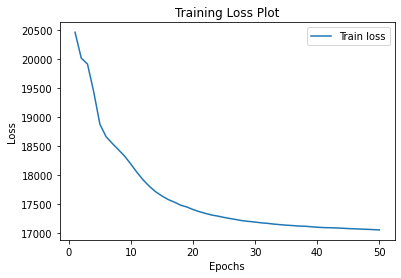

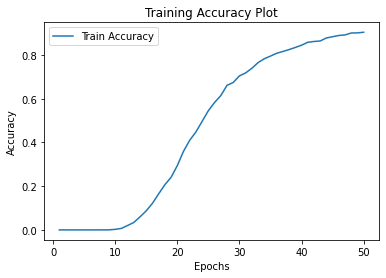

In [ ]:
train_model(NeuralNetModel)

In [ ]:
test_model(NeuralNetModel)

1858
Accuracy of Neural Network is 0.9290


In [ ]:
print_wrong_predictions(NeuralNetModel)

5b2-1K5B-2n5-3N4-4P3-8-8-4k1R1 | 5b2-1K5B-2n5-3N4-4P3-8-8-2q1k1R1
Predicted Position


True Position



3b4-8-5B2-2Pp2k1-8-N1K5-1Q2P2q-4N3 | 3b4-8-5B2-2Pp2k1-8-N1K5-1Q2P2q-4NR2
Predicted Position


True Position



8-1b6-8-1Q1Kb3-3n4-8-3R1k2-8 | 8-1b6-8-1Q1Kb3-3n1Q2-8-3R1k2-8
Predicted Position


True Position



8-3K4-1N6-4P3-P2b1Q1b-8-R5p1-B5b1 | 8-3K4-1N6-4P3-P2b1Q1k-8-R5p1-B5b1
Predicted Position


True Position



K7-5p2-nkQ1B1R1-6b1-1N6-6R1-2n1b3-2n5 | K7-5p2-nkQ1B1R1-6b1-1N6-6RN-2n1b3-2n5
Predicted Position


True Position



3n4-4p3-b5pq-2K1n1R1-6N1-2N2k2-8-8 | 3n4-4p3-b5pq-2K1n1R1-6N1-2N2k2-8-2n5
Predicted Position


True Position


## ConvMixer

Convolutional Mixers propose to divide the input into patches. This can be done with a convolutional layer where kernel size = patch size. Moreover, through the same convolutional layer, we create an embedding of each patch by applying the element-wise product of each kernel and the patch. 

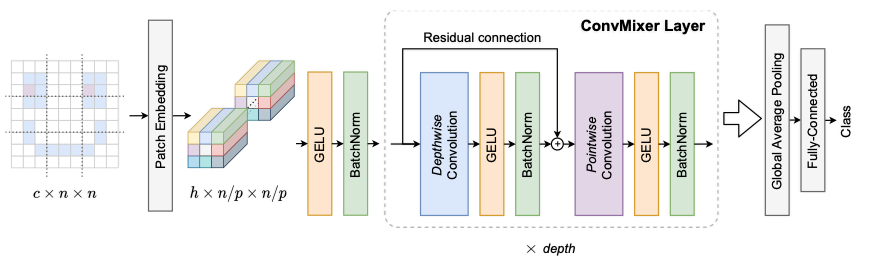


Link to Paper: https://openreview.net/pdf?id=TVHS5Y4dNvM


Parameters: 

Design parameters. An instantiation of ConvMixer depends on four parameters: (1) the “width” or hidden dimension h (i.e., the dimension of the patch embeddings), (2) the depth d, or the number of repetitions of the ConvMixer layer, (3) the patch size p which controls the internal resolution of the
Residual connection model, (4) the kernel size k of the depthwise convolutional layer.



Parameter decision

Since the image is 240 x 240, and perfectly adjusted to the chess grid, we choose the patch size to be 30 x 30 to accomodate one patch to each chess cell. 

For our model, we are choosing the width to be 30 such that each patch corressponds to a cell. 

In [ ]:
class Residual(nn.Module): 
    def __init__(self, fn):
      super().__init__()
      self.fn = fn

    def forward(self, x): 
      return self.fn(x) + x

class ConvMixer(nn.Module):
  def __init__(self, dim = 900, depth = 1, kernel_size = 8, patch_size = 30):
    super(ConvMixer, self).__init__()
    self.get_patches = nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size)
    self.gelu = nn.GELU()
    self.batchNorm = nn.BatchNorm2d(dim)
    self.flatten = nn.Flatten()

    self.convmixlayer = nn.Sequential(
        *[nn.Sequential(
            Residual(
              nn.Sequential(
                nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=kernel_size, padding=0), 
                nn.GELU(),
                nn.BatchNorm2d(dim)
              )
            ),
            nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm2d(dim)
    ) for i in range(depth)])

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.linear = nn.Linear(dim, 64*13)

  def forward(self, x):
    # Divide input into patches
    x = self.get_patches(x)
    x = self.gelu(x)
    x = self.batchNorm(x)
    # print(x.shape)
    # Apply convolutional layer
    x = self.convmixlayer(x)
    # Average pooling and linear layer
    x = self.avg_pool(x)
    x = self.flatten(x)
    x = self.linear(x)
    return x

Train and test ConvMix model

In [ ]:
convMixModel = ConvMixer(depth=2)

train_data_loader = DataLoader(train_data, batch_size=128, num_workers=2,
                               shuffle=True, drop_last=False)
test_data_loader = DataLoader(test_data, batch_size=128, num_workers=2,
                              shuffle=True, drop_last=False)

In [ ]:
summary(convMixModel, input_size=(128, 1, 240, 240))

Layer (type:depth-idx)                        Output Shape              Param #
ConvMixer                                     [128, 832]                --
├─Conv2d: 1-1                                 [128, 900, 8, 8]          810,900
├─GELU: 1-2                                   [128, 900, 8, 8]          --
├─BatchNorm2d: 1-3                            [128, 900, 8, 8]          1,800
├─Sequential: 1-4                             [128, 900, 8, 8]          --
│    └─Sequential: 2-1                        [128, 900, 8, 8]          --
│    │    └─Residual: 3-1                     [128, 900, 8, 8]          51,842,700
│    │    └─Conv2d: 3-2                       [128, 900, 8, 8]          810,900
│    │    └─GELU: 3-3                         [128, 900, 8, 8]          --
│    │    └─BatchNorm2d: 3-4                  [128, 900, 8, 8]          1,800
│    └─Sequential: 2-2                        [128, 900, 8, 8]          --
│    │    └─Residual: 3-5                     [128, 900, 8, 8]         

epoch: 1, loss: 23939.0286, accuracy: 0.0000
epoch: 2, loss: 19211.2981, accuracy: 0.0000
epoch: 3, loss: 18532.1919, accuracy: 0.0000
epoch: 4, loss: 18355.0297, accuracy: 0.0005
epoch: 5, loss: 18223.9020, accuracy: 0.0019
epoch: 6, loss: 18099.8371, accuracy: 0.0049
epoch: 7, loss: 17972.3155, accuracy: 0.0168
epoch: 8, loss: 17837.2244, accuracy: 0.0510
epoch: 9, loss: 17820.9090, accuracy: 0.0905
epoch: 10, loss: 17625.4804, accuracy: 0.2185
epoch: 11, loss: 17540.4347, accuracy: 0.3478
epoch: 12, loss: 17476.3356, accuracy: 0.4704
epoch: 13, loss: 17450.2771, accuracy: 0.5337
epoch: 14, loss: 17473.6511, accuracy: 0.5048
epoch: 15, loss: 17450.7153, accuracy: 0.5004
epoch: 16, loss: 17270.4365, accuracy: 0.7093
epoch: 17, loss: 17200.2290, accuracy: 0.8159
epoch: 18, loss: 17163.8151, accuracy: 0.8604
epoch: 19, loss: 17177.4890, accuracy: 0.8521
epoch: 20, loss: 17162.2266, accuracy: 0.8589
epoch: 21, loss: 17136.4158, accuracy: 0.8829
epoch: 22, loss: 17112.7043, accuracy: 0.90

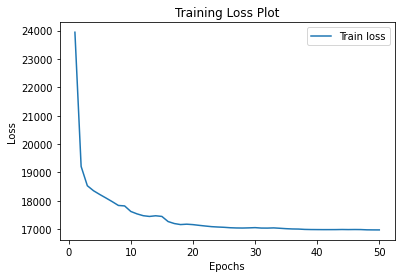

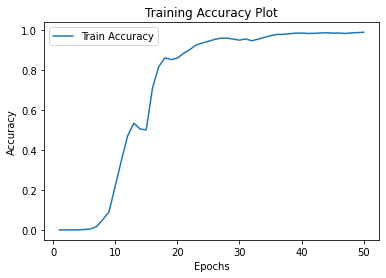

In [ ]:
convMixModel = convMixModel.to('cuda')

train_model(convMixModel)

In [ ]:
test_model(convMixModel)

1977
Accuracy of Neural Network is 0.9885


In [ ]:
print_wrong_predictions(convMixModel)

N1q5-8-5B2-2N1p2P-n5b1-6k1-2KP4-2r5 | N1qq4-8-5B2-2N1p2P-n5b1-6k1-2KP4-2r5
Predicted Position


True Position



bN6-7p-4rPk1-N2K2RN-6n1-8-3Q4-7Q | bN6-b6p-4rPk1-N2K2RN-6n1-8-3Q4-7Q
Predicted Position


True Position



3NK1b1-2P4B-2p2P2-5B2-3PB3-4P1nN-8-8 | 3NK1b1-2P4B-2p2P2-5B1k-3PB3-4P1nN-8-8
Predicted Position


True Position
